In [2]:
import numpy as np
import pandas as pd
import featuretools as ft
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

from sklearn import preprocessing

# load data
sunshine = pd.read_csv("Dataset/sunshine.csv")
temp = pd.read_csv("Dataset/temp.csv")
wind = pd.read_csv("Dataset/wind.csv")

combi = sunshine.merge(temp, on=['Day', 'Hour'], how='left').merge(wind, on=['Day', 'Hour'], how='left').reset_index(drop=False)
Radiation = combi['Radiation']
# combi.drop(['Radiation'], axis=1, inplace=True)

In [3]:
Temp_day = temp.groupby(['Day'])['Temp'].mean().to_frame('Temp_day').reset_index()
Radiation_day = sunshine.groupby(['Day'])['Radiation'].median().to_frame('Radiation_day').reset_index()
combi = combi.merge(Temp_day, on=['Day'], how='left')
combi = combi.merge(Radiation_day, on=['Day'], how='left')

In [4]:
combi['Radia'] = combi['Radiation'] / combi['Radiation_day']

In [5]:
def feat_kernelMedian(df, df_feature, fe, value, pr, name=""):
    def get_median(a, pr=pr):
        a = np.array(a)
        x = a[~np.isnan(a)]
        n = len(x)
        weight = np.repeat(1.0, n)
        idx = np.argsort(x)
        x = x[idx]
        if n<pr.shape[0]:
            pr = pr[n,:n]
        else:
            scale = (n-1)/2.
            xxx = np.arange(-(n+1)/2.+1, (n+1)/2., step=1)/scale
            yyy = 3./4.*(1-xxx**2)
            yyy = yyy/np.sum(yyy)
            pr = (yyy*n+1)/(n+1)
        ans = np.sum(pr*x*weight) / float(np.sum(pr * weight))
        return ans

    df_count = pd.DataFrame(df_feature.groupby(fe)[value].apply(get_median)).reset_index()
    if not name:
        df_count.columns = fe + [value+"_%s_mean" % ("_".join(fe))]
    else:
        df_count.columns = fe + [name]
    df = df.merge(df_count, on=fe, how="left").fillna(0)
    return df

# Feiyang: 1. 获得核函数 PrEp
PrOriginalEp = np.zeros((2000,2000))
PrOriginalEp[1,0] = 1
PrOriginalEp[2,range(2)] = [0.5,0.5]
for i in range(3,2000):
    scale = (i-1)/2.
    x = np.arange(-(i+1)/2.+1, (i+1)/2., step=1)/scale
    y = 3./4.*(1-x**2)
    y = y/np.sum(y)
    PrOriginalEp[i, range(i)] = y
PrEp = PrOriginalEp.copy()
for i in range(3, 2000):
    PrEp[i,:i] = (PrEp[i,:i]*i+1)/(i+1)

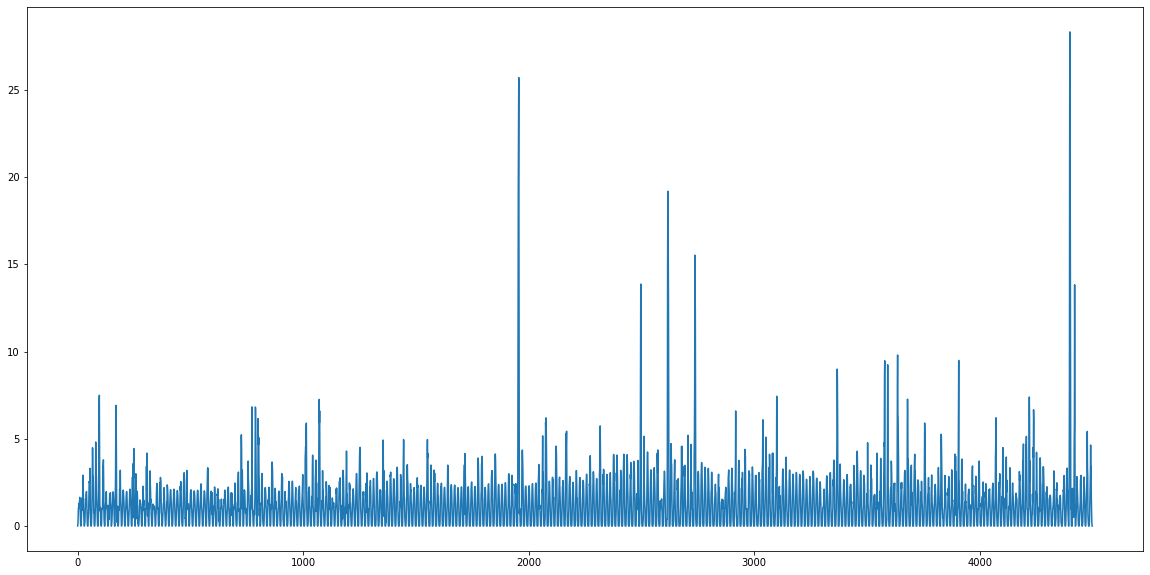

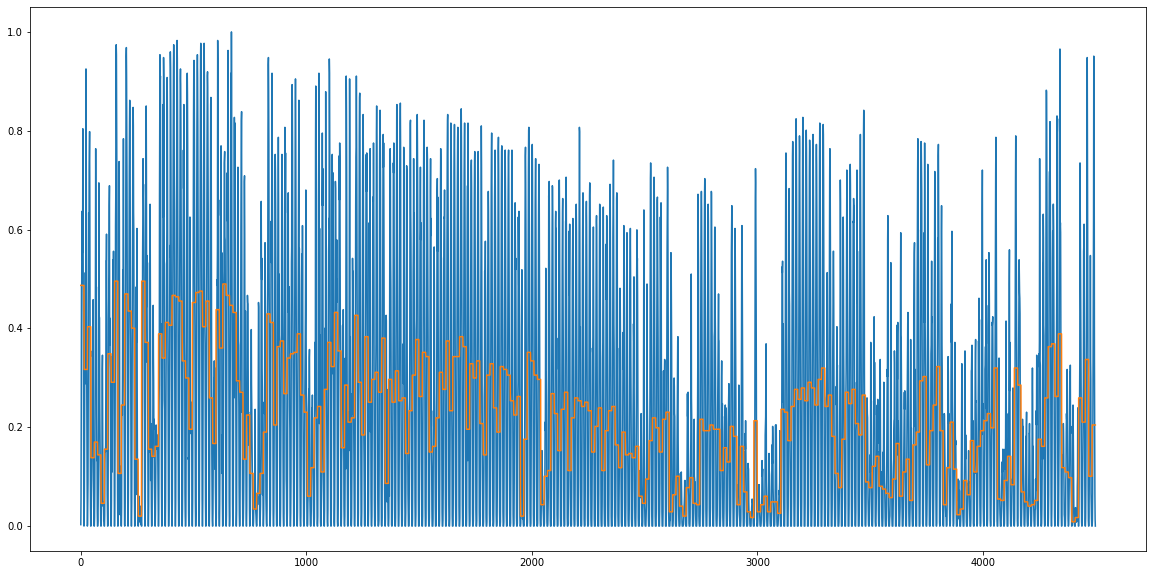

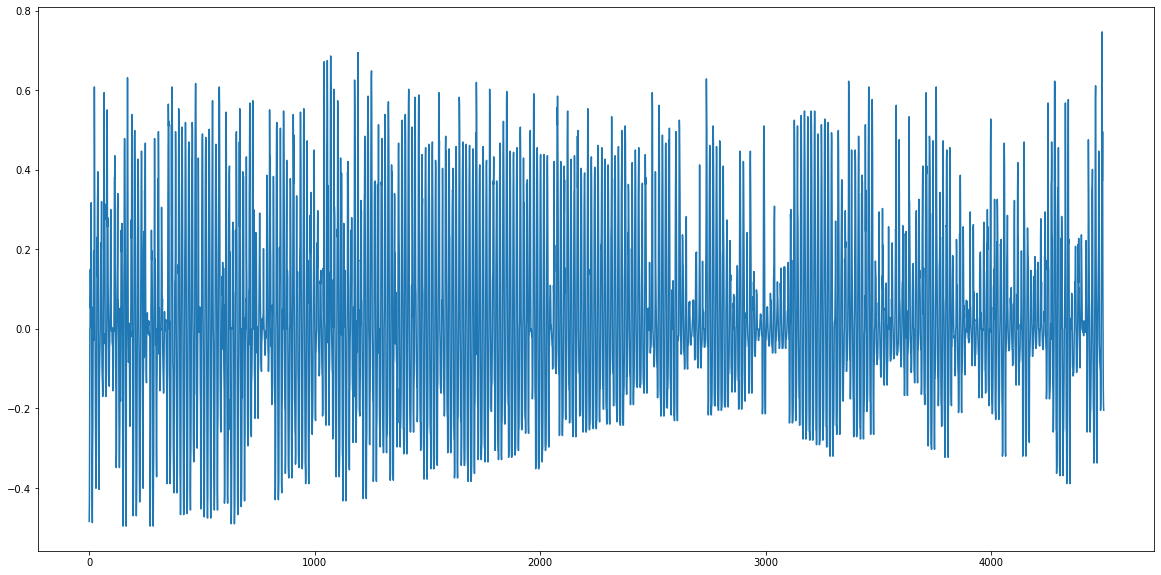

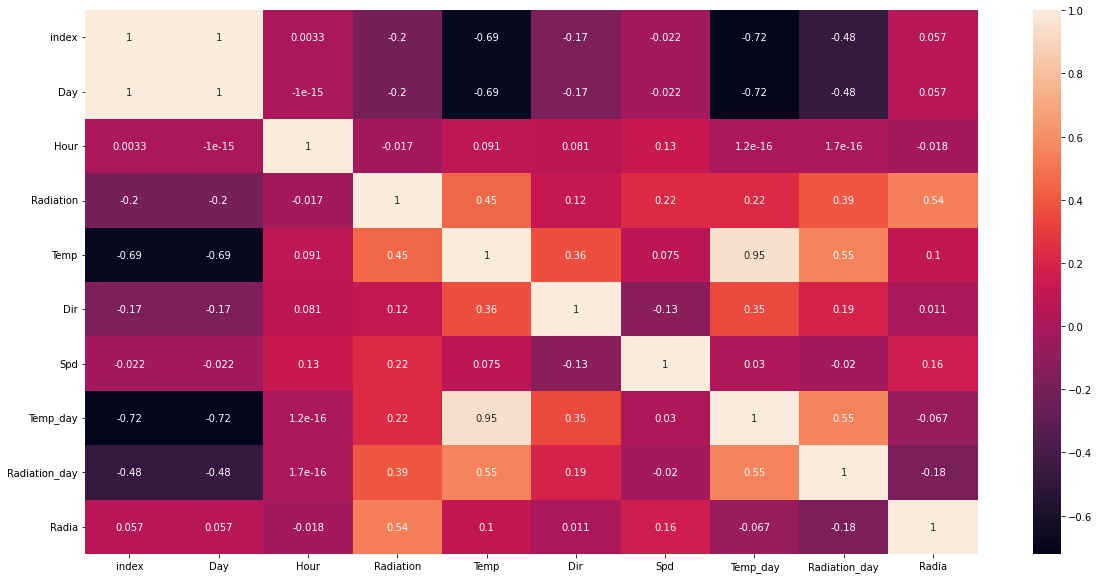

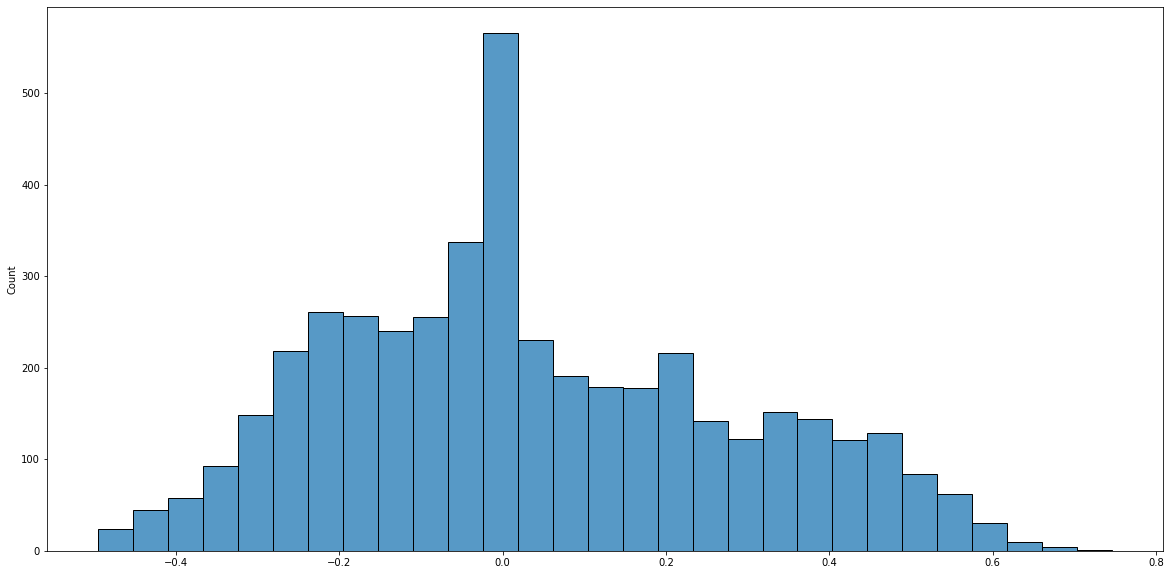

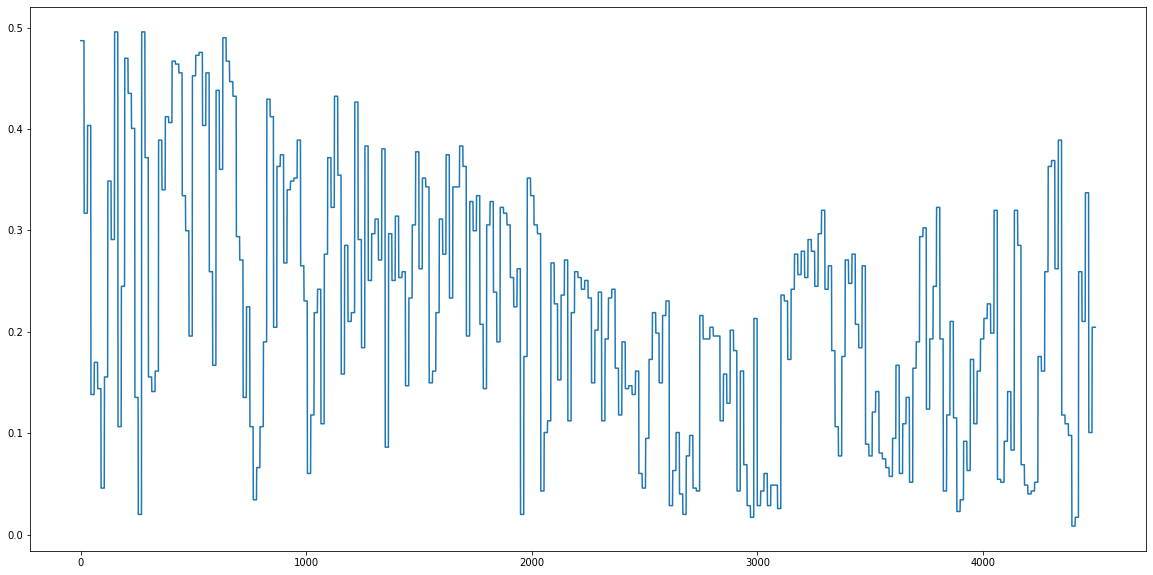

In [68]:
plt.figure(figsize=(20, 10))
plt.plot(combi['Radia'])

plt.figure(figsize=(20, 10))
plt.plot(combi['Radiation'])
plt.plot(combi['Radiation_day'])

plt.figure(figsize=(20, 10))
plt.plot(combi['Radiation'] - combi['Radiation_day'])

import seaborn as sns
plt.figure(figsize=(20, 10))
sns.heatmap(combi.corr(), annot=True)
plt.figure(figsize=(20, 10))
sns.histplot(combi['Radiation'] - combi['Radiation_day'])

plt.figure(figsize=(20, 10))
plt.plot(combi['Radiation_day'])
